In [1]:
from jazzy.core import get_lone_pairs
from jazzy.core import get_covalent_atom_idxs
from jazzy.core import get_acceptor_atom_strength
from jazzy.core import get_atom_and_nbrs_charges
from jazzy.core import get_charges_from_atom_list
from jazzy.core import get_donor_atom_strength
from jazzy.core import calculate_polar_strength_map

from jazzy.core import GetPeriodicTable

from kallisto.methods import getPolarizabilities
from kallisto.methods import getAtomicPartialCharges
from kallisto.atom import Atom
from kallisto.molecule import Molecule
from kallisto.units import Bohr
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from rdkit import Chem
from rdkit.Chem import AllChem

import config

from helpers import get_cm5_corrections_dict
from helpers import kallisto_molecule_from_rdkit_molecule
from helpers import MolsFromSpartanFiles
from helpers import get_SMARTS_matches

/home/chris/miniconda3/envs/kallisto/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

ROUNDING_DIGITS = 4

def kallisto_molecule_from_rdkit_molecule(rdkit_molecule: Chem.rdchem.Mol) -> Molecule:
    """Create a kallisto molecule from RDKit molecule.

    Args:
    rdkit_molecule: RDKit molecule

    Returns:
    A kallisto molecule (kallisto.molecule.Molecule)

    Raises:
    KallistoError: An error if the kallisto molecule cannot be created

    """
    # get the name of the molecule if it comes from SDF
    name = ""
    if rdkit_molecule.HasProp("_Name"):
        name = rdkit_molecule.GetProp("_Name")
    # get all xyz coordinates and split into list of lines
    xyz = Chem.rdmolfiles.MolToXYZBlock(rdkit_molecule).split("\n")
    # remove empty lines or molecule name from list
    xyz = [string for string in xyz if string != "" and string != name]
    # remove number of atoms as given in xmol files (first line)
    xyz = xyz[1:]

    # setup periodic table
    pt = Chem.GetPeriodicTable()
    # create list of atoms
    atoms = []
    # create kallisto molecule
    for coord in xyz:
        elem, x, y, z = coord.split()[:4]

        # convert atomic coordinates from Angstrom to Bohr
        position = [float(x) / Bohr, float(y) / Bohr, float(z) / Bohr]
        atom = Atom(symbol=pt.GetAtomicNumber(elem), position=position)
        atoms.append(atom)
    kallisto_mol = Molecule(symbols=atoms)
    if "numbers" not in kallisto_mol.arrays.keys():
        raise KeyError(
            "The kallisto molecule was not created for the input '{}'".format(
                Chem.MolToSmiles(rdkit_molecule)
            )
        )
    return kallisto_mol
    
mols = [x for x in Chem.SDMolSupplier("../data/qm_charges/all_mols_def2TZVP_charges_cm5.sdf",removeHs=False)]
pkbhx = np.genfromtxt("../data/qm_charges/pkbhx.txt")

In [3]:
### New A and D values for Kallisto charges with CM5 charges

mol = Chem.MolFromSmiles("O")
mol = AllChem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)

kmol = kallisto_molecule_from_rdkit_molecule(mol)
atoms_and_nbrs = get_covalent_atom_idxs(mol)

charges = kmol.get_eeq(0, True)
H2O_sa = get_acceptor_atom_strength(0, atoms_and_nbrs, charges, 1, 0.274)

print("H2O Acceptor Strength with CM5 Corrections: {}".format(H2O_sa))

CM5_a = np.round(1/H2O_sa, 4)

print("New correction factor a: {}".format(CM5_a))

H2O_sd = get_donor_atom_strength(1, atoms_and_nbrs, charges, 1, 0.274)

print("H2O donor Strength with CM5 Corrections: {}".format(H2O_sd))

CM5_d = np.round(1/H2O_sd, 4)

print("New correction factor d: {}".format(CM5_d))

H2O Acceptor Strength with CM5 Corrections: -0.6853553355048334
New correction factor a: -1.4591
H2O donor Strength with CM5 Corrections: 0.2487841476240425
New correction factor d: 4.0195


In [4]:
import config

CM5_ATOMIC_PARAMETERS = config.CM5_PARAMETERS_UNMODIFIED

def get_cm5_corrections(at: list, coords: np.ndarray) -> np.ndarray:
    """A method to get CM5 corrections for hirshfeld charges.

    Args:
    at - atomic numbers (list of integers)
    coords - atomic coordinates (np.ndarray)

    Returns:
    cm5_corrections - list of cm5 corrections (np.ndarray)
    """

    from kallisto.data import chemical_symbols
    from kallisto.data import ATOMIC_RCOV
    # from kallisto.data import CM5_ATOMIC_PARAMETERS

    # Constant for bond order calculation in Angstrom
    alpha = -2.474 / 1.88973

    # Initialise per atom correction terms array
    at_corr = np.zeros((len(at), len(at)))

    # Iterate through atom pairs
    for i in range(len(at)):
        for j in range(i, len(at)):
            if i != j:
                i_sym = chemical_symbols[int(at[i])]
                j_sym = chemical_symbols[int(at[j])]

                # Calculate Pauling bond order
                dij = np.sqrt(np.sum((coords[i] - coords[j]) ** 2))
                Bkk = np.exp(alpha * (dij - ATOMIC_RCOV[i_sym] - ATOMIC_RCOV[j_sym]))

                # Retrieve CM5 atomic paramters from dict
                if (i_sym, j_sym) in CM5_ATOMIC_PARAMETERS.keys():
                    Dkk = CM5_ATOMIC_PARAMETERS[(i_sym, j_sym)]
                elif (j_sym, i_sym) in CM5_ATOMIC_PARAMETERS.keys():
                    # Negative to satisfy Dkk' = -Dk'k
                    Dkk = -CM5_ATOMIC_PARAMETERS[(j_sym, i_sym)]
                else:
                    Dkk = CM5_ATOMIC_PARAMETERS[i_sym] - CM5_ATOMIC_PARAMETERS[j_sym]
                    
                # Calculate atomic corrections
                # Atom pairs have negative correction to satisfy Dkk' = -Dk'k
                at_corr[i, j] = Bkk * Dkk
                at_corr[j, i] = -Bkk * Dkk

    # Return per atom sum
    return np.sum(at_corr, axis=1)

In [5]:
def plot_with_linregress(ax, x, y, minx=None, maxx=None, marker="x", color="black"):
    # Scatter plot
    ax.scatter(x, y, marker=marker, color=color)

    # Determine min and max x values for regression line if not provided
    if minx is None:
        minx = np.min(x)
    if maxx is None:
        maxx = np.max(x)

    # Perform linear regression with specified minx and maxx
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    x_line = np.array([minx, maxx])
    y_line = slope * x_line + intercept

    # Plot the regression line
    ax.plot(x_line, y_line, linestyle="--", color="red")

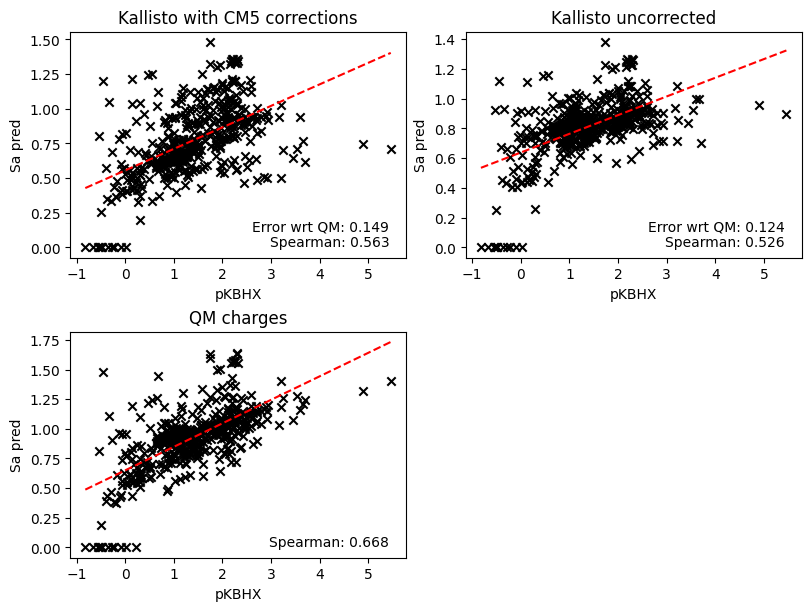

In [7]:
qm_sa = []
kallisto_sa = []
kallisto_sa_uncorr = []

charge_error = []
charge_error_uncorr = []

qm_charge_list = []
kallisto_charge_list = []
cm5_charge_list = []

pkb = []

include = []

for i,mol in enumerate(mols):
    qm_charges = np.array([float(x) for x in mols[i].GetProp("chelpg_charges").split(",")])
    kallisto_molecule = kallisto_molecule_from_rdkit_molecule(mol)
    at = kallisto_molecule.get_atomic_numbers()
    coords = kallisto_molecule.get_positions()
    cns = kallisto_molecule.get_cns("cov")
    atoms_and_nbrs = get_covalent_atom_idxs(mol)
    charge = np.sum([atom.GetFormalCharge() for atom in mol.GetAtoms()])
    graph = kallisto_molecule.get_bonds()

    kallisto_charges_uncorr = getAtomicPartialCharges(at, coords, cns, charge)
    CM5_correction = get_cm5_corrections(at, coords)
    kallisto_charges = kallisto_charges_uncorr + CM5_correction

    qm_charge_list.append(qm_charges)
    kallisto_charge_list.append(kallisto_charges_uncorr)
    cm5_charge_list.append(kallisto_charges)

    charge_error.append(kallisto_charges - qm_charges)
    charge_error_uncorr.append(kallisto_charges_uncorr - qm_charges)

    qm_strengths = calculate_polar_strength_map(mol, kallisto_molecule, atoms_and_nbrs, list(qm_charges))
    kallisto_strengths = calculate_polar_strength_map(mol, kallisto_molecule, atoms_and_nbrs, list(kallisto_charges), a=CM5_a, d =CM5_d)
    kallisto_strengths_uncorr = calculate_polar_strength_map(mol, kallisto_molecule, atoms_and_nbrs, list(kallisto_charges_uncorr))

    qm_sa.append(max([qm_strengths[x]["sa"] for x in qm_strengths.keys()]))
    kallisto_sa.append(max([kallisto_strengths[x]["sa"] for x in kallisto_strengths.keys()]))
    kallisto_sa_uncorr.append(max([kallisto_strengths_uncorr[x]["sa"] for x in kallisto_strengths_uncorr.keys()]))
    pkb.append(pkbhx[i])


fig, axs = plt.subplots(2,2,figsize=(8,6), layout="constrained")

plot_with_linregress(axs[0,0], pkb, kallisto_sa,)
plot_with_linregress(axs[0,1], pkb ,kallisto_sa_uncorr,)
plot_with_linregress(axs[1,0], pkb, qm_sa,)

for ax in axs.flatten()[:-1]:
    ax.set_ylabel("Sa pred")
    ax.set_xlabel("pKBHX")

axs[0,0].set_title("Kallisto with CM5 corrections")
axs[0,1].set_title("Kallisto uncorrected")
axs[1,0].set_title("QM charges")

axs[0,0].text(0.95,0.05,"Spearman: {:.3f}".format(stats.spearmanr(kallisto_sa, pkb, )[0]), transform=axs[0,0].transAxes, horizontalalignment="right")
axs[0,1].text(0.95,0.05,"Spearman: {:.3f}".format(stats.spearmanr(kallisto_sa_uncorr, pkb, )[0]), transform=axs[0,1].transAxes, horizontalalignment="right")
axs[1,0].text(0.95,0.05,"Spearman: {:.3f}".format(stats.spearmanr(qm_sa, pkb, )[0]), transform=axs[1,0].transAxes, horizontalalignment="right")

axs[0,0].text(0.95,0.12,"Error wrt QM: {:.3f}".format(np.mean([np.mean(np.abs(x)) for x in charge_error])), transform=axs[0,0].transAxes, horizontalalignment="right")
axs[0,1].text(0.95,0.12,"Error wrt QM: {:.3f}".format(np.mean([np.mean(np.abs(x)) for x in charge_error_uncorr])), transform=axs[0,1].transAxes, horizontalalignment="right")


axs[1, 1].axis('off')

plt.show()

SignificanceResult(statistic=0.679670608015862, pvalue=2.620367595323321e-59)


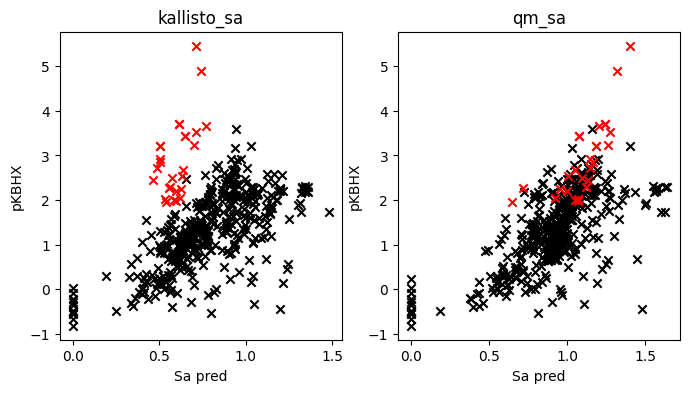

In [28]:
inds = np.where(((np.array(kallisto_sa) < 0.9)*(pkbhx > 3)))[0]
inds2 = np.where(((np.array(kallisto_sa) < 0.65)*(pkbhx > 1.8)))[0]
bad_inds = np.concatenate([inds, inds2])

inds = [i for i in range(len(kallisto_sa)) if i not in np.concatenate([inds, inds2])]

fig, axs = plt.subplots(1,2,figsize=(8,4))

axs[0].scatter(np.array(kallisto_sa)[inds], pkbhx[inds], marker="x", color="black")
axs[0].scatter(np.array(kallisto_sa)[bad_inds], pkbhx[bad_inds], marker="x", color="red")
axs[0].set_title("kallisto_sa")

axs[1].scatter(np.array(qm_sa)[inds], pkbhx[inds], marker="x", color="black")
axs[1].scatter(np.array(qm_sa)[bad_inds], pkbhx[bad_inds], marker="x", color="red")
axs[1].set_title("qm_sa")

for ax in axs.flatten():
    ax.set_xlabel("Sa pred")
    ax.set_ylabel("pKBHX")

print(stats.spearmanr(np.array(kallisto_sa)[inds], pkbhx[inds], ))


SignificanceResult(statistic=0.6280758016694513, pvalue=5.119670004075619e-48)


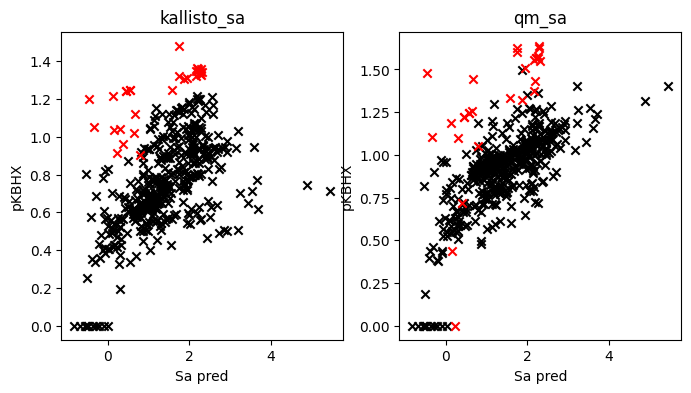

In [61]:
inds = np.where(((np.array(kallisto_sa) > 0.9)*(pkbhx < 0.8)))[0]
inds2 = np.where((np.array(kallisto_sa) > 1.23))[0]
bad_inds2 = np.concatenate([inds, inds2])
inds = [i for i in range(len(kallisto_sa)) if i not in np.concatenate([inds, inds2])]

fig, axs = plt.subplots(1,2,figsize=(8,4))

axs[0].scatter(pkbhx[inds], np.array(kallisto_sa)[inds], marker="x", color="black")
axs[0].scatter(pkbhx[bad_inds2], np.array(kallisto_sa)[bad_inds2], marker="x", color="red")
axs[0].set_title("kallisto_sa")

axs[1].scatter(pkbhx[inds], np.array(qm_sa)[inds], marker="x", color="black")
axs[1].scatter( pkbhx[bad_inds2], np.array(qm_sa)[bad_inds2],marker="x", color="red")
axs[1].set_title("qm_sa")

for ax in axs.flatten():
    ax.set_xlabel("Sa pred")
    ax.set_ylabel("pKBHX")

print(stats.spearmanr(np.array(kallisto_sa)[inds], pkbhx[inds], ))


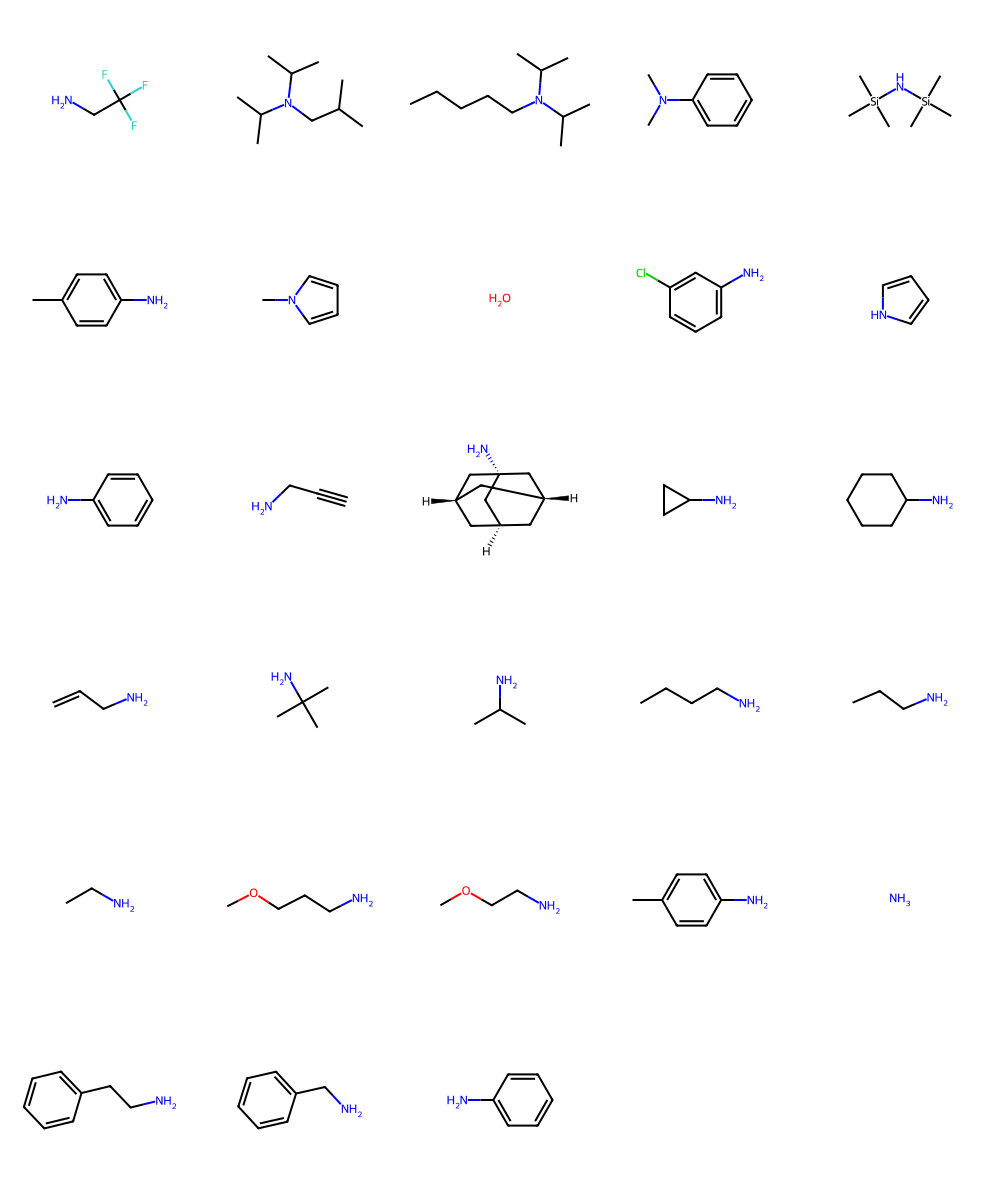

In [9]:
from rdkit.Chem import Draw

Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mols[x])) for x in bad_inds2], molsPerRow=5, useSVG=True)


28


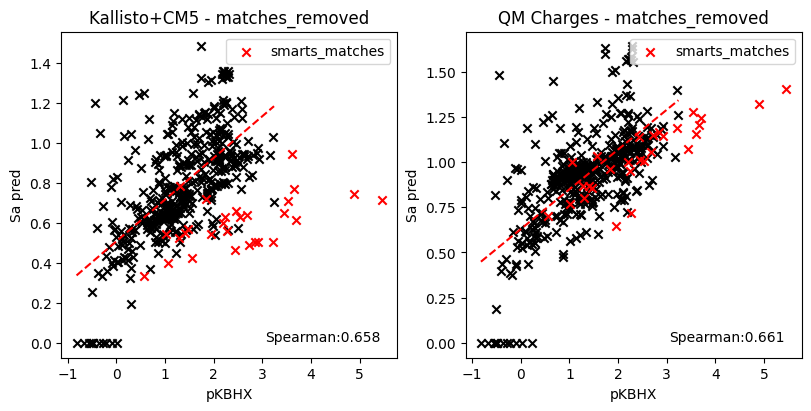

In [30]:
smarts_patterns = [
    "[NX2,nX3][OX1]",  # General N-O single bond
    "[N+;!$(N(=O)[O-])][O-]",
    "[n+][O-]",
    "[n][n]",
    "[C][S]=[O]", # S=O double bond
    "[P]=[O]",  # P=O double bond
    "[As]",
    "[Se]"
]

smarts_patterns = [Chem.MolFromSmarts(x) for x in smarts_patterns]

n_oxides = []
for i,mol in enumerate(mols):
    if any(mol.HasSubstructMatch(smarts) for smarts in smarts_patterns):
        n_oxides.append(i)

inds = [i for i in range(len(kallisto_sa)) if i not in n_oxides]

print(len(n_oxides))


fig, axs = plt.subplots(1,2,figsize=(8,4), layout="constrained")

plot_with_linregress(axs[0],pkbhx[inds], np.array(kallisto_sa)[inds])
# axs[0].scatter(pkbhx[inds], np.array(kallisto_sa)[inds], color="black",marker="x")
axs[0].scatter(pkbhx[n_oxides], np.array(kallisto_sa)[n_oxides], color="red",marker="x", label="smarts_matches")
axs[0].legend()
axs[0].set_title("Kallisto+CM5 - matches_removed")
axs[0].text(0.95,0.05,"Spearman:{:.3f}".format(stats.spearmanr(np.array(kallisto_sa)[inds], pkbhx[inds], )[0]), transform=axs[0].transAxes, horizontalalignment="right")

plot_with_linregress(axs[1],pkbhx[inds], np.array(qm_sa)[inds])
axs[1].scatter(pkbhx[n_oxides], np.array(qm_sa)[n_oxides], color="red",marker="x", label="smarts_matches")
axs[1].legend(loc="upper right")
axs[1].set_title("QM Charges - matches_removed")

axs[1].text(0.95,0.05,"Spearman:{:.3f}".format(stats.spearmanr(np.array(qm_sa)[inds], pkbhx[inds], )[0]), transform=axs[1].transAxes, horizontalalignment="right")

for ax in axs.flatten():
    ax.set_ylabel("Sa pred")
    ax.set_xlabel("pKBHX")

plt.show()

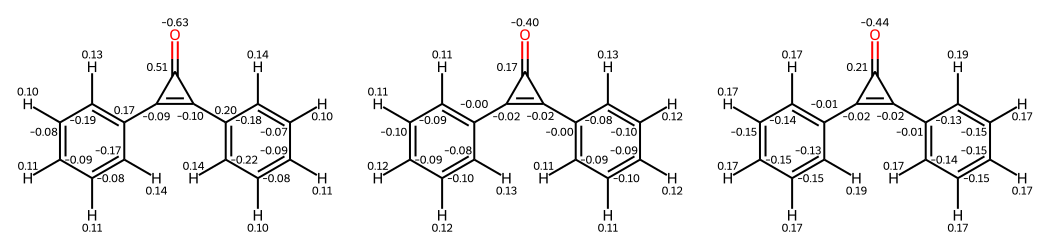

In [60]:
from copy import deepcopy
from rdkit import IPythonConsole
IPythonConsole.drawOptions.annotationFontScale = 0.75

display_mols = []
for j in np.array(bad_inds)[18:19]:
    # Create an rdkit mol object
    mol1 = deepcopy(mols[j])
    AllChem.Compute2DCoords(mol1)
    mol2 = deepcopy(mol1)
    mol3 = deepcopy(mol1)

    # qm_charges = [float(atom.GetProp("_TriposPartialCharge")) for atom in mol1.GetAtoms()]
    qm_charges = [float(x) for x in mol1.GetProp("chelpg_charges").split(",")]

    k_charges = kallisto_charge_list[j]
    cm5_charges = cm5_charge_list[j]

    # Iterate over the atoms
    for i,atom in enumerate(mol1.GetAtoms()):
        # For each atom, set the property "atomNote" to a index+1 of the atom
        atom.SetProp("atomNote", "{:.2f}".format(qm_charges[i]))
    for i,atom in enumerate(mol2.GetAtoms()):
        # For each atom, set the property "atomNote" to a index+1 of the atom
        atom.SetProp("atomNote", "{:.2f}".format(k_charges[i]))
    for i,atom in enumerate(mol3.GetAtoms()):
        # For each atom, set the property "atomNote" to a index+1 of the atom
        atom.SetProp("atomNote", "{:.2f}".format(cm5_charges[i]))
    display_mols += [mol1, mol2, mol3]

Chem.Draw.MolsToGridImage(display_mols, subImgSize=(350,250), molsPerRow=3, useSVG=False)

96


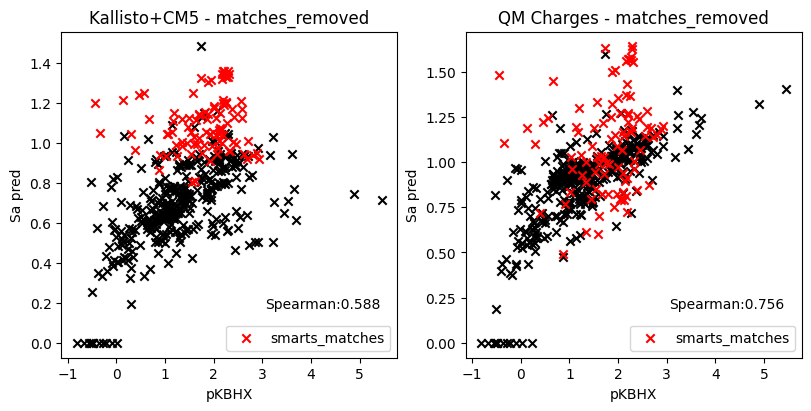

In [23]:
smarts_patterns = [
                "[NX3;!$(NC=O);!$(NC=S);!$(NS=O);!$(NP=O);!$(N#C);!$([N+](=O)[O-]);!$(NC=C);!$(NC=N);!$(NC#C);H2,H1,H0]", "[a][NX3;!$(NC=O);!$(NC#C);!$([N+](=O)[O-]);H2,H1,H0]"
]

smarts_patterns = [Chem.MolFromSmarts(x) for x in smarts_patterns]

amines = []
for i,mol in enumerate(mols):
    if any(mol.HasSubstructMatch(smarts) for smarts in smarts_patterns):
        amines.append(i)

inds = [i for i in range(len(kallisto_sa)) if i not in amines]

print(len(amines))


fig, axs = plt.subplots(1,2,figsize=(8,4), layout="constrained")

axs[0].scatter(pkbhx[inds], np.array(kallisto_sa)[inds], color="black",marker="x")
axs[0].scatter(pkbhx[amines], np.array(kallisto_sa)[amines], color="red",marker="x", label="smarts_matches")
axs[0].legend(loc="lower right")
axs[0].set_title("Kallisto+CM5 - matches_removed")
axs[0].text(0.95,0.15,"Spearman:{:.3f}".format(stats.spearmanr(np.array(kallisto_sa)[inds], pkbhx[inds], )[0]), transform=axs[0].transAxes, ha="right")

axs[1].scatter(pkbhx[inds], np.array(qm_sa)[inds], color="black",marker="x")
axs[1].scatter(pkbhx[amines], np.array(qm_sa)[amines], color="red",marker="x", label="smarts_matches")
axs[1].legend()
axs[1].set_title("QM Charges - matches_removed")

axs[1].text(0.95,0.15,"Spearman:{:.3f}".format(stats.spearmanr(np.array(qm_sa)[inds], pkbhx[inds], )[0]), transform=axs[1].transAxes, ha="right")

for ax in axs.flatten():
    ax.set_ylabel("Sa pred")
    ax.set_xlabel("pKBHX")

plt.show()

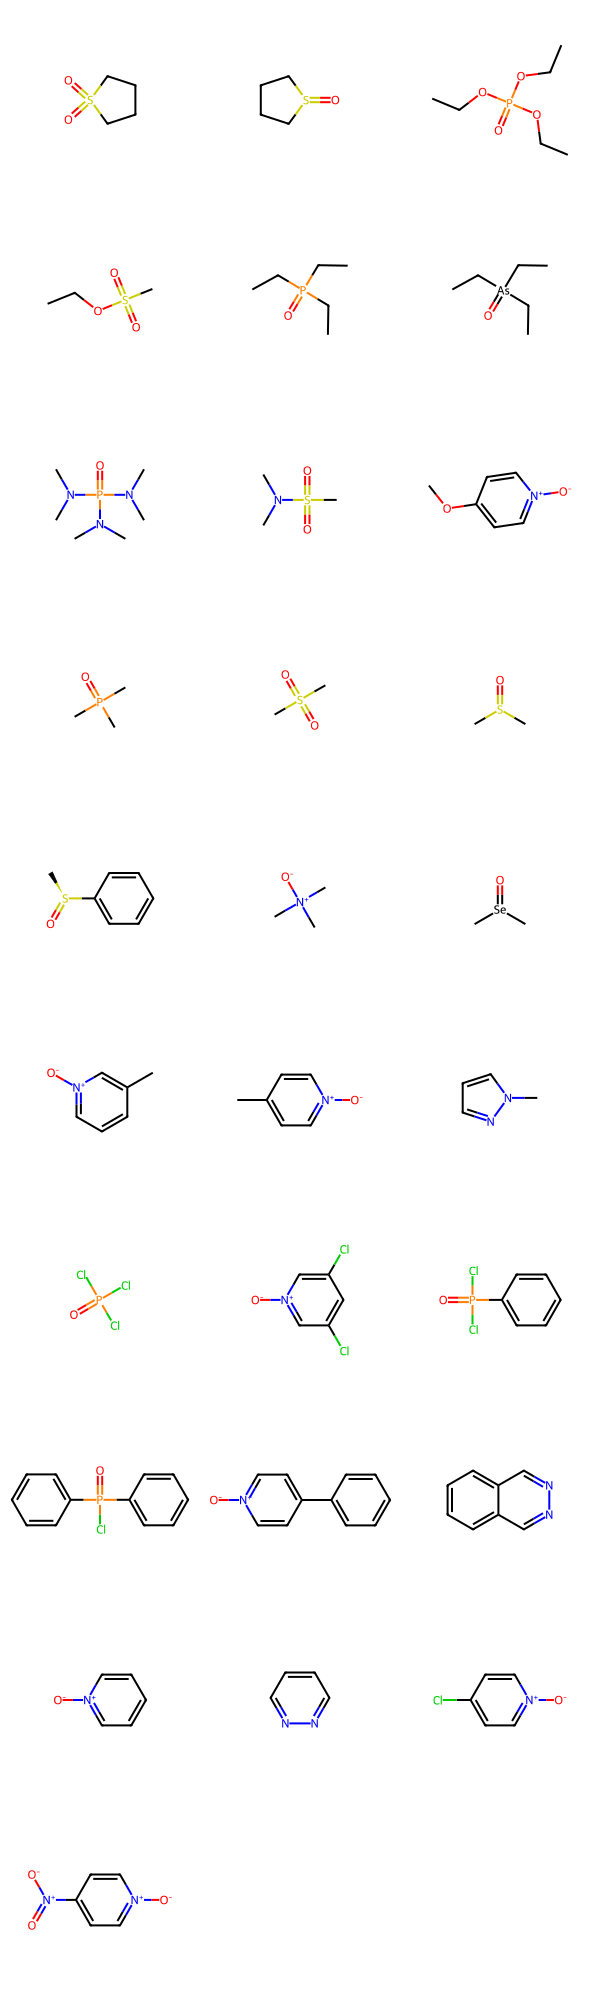

In [14]:
from rdkit.Chem import Draw

remaining_inds = [x for x in bad_inds if x not in n_oxides]

Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mols[x])) for x in n_oxides[:50]], useSVG=True)
